In [ ]:
#| hide
import os
os.chdir('..')

# End to end walkthrough

> Detailed description of all the functionalities that MLForecast provides.

## Data setup

For this example we'll use a subset of the M4 hourly dataset. You can find the a notebook with the full dataset [here](https://www.kaggle.com/code/lemuz90/m4-competition).

In [ ]:
import random

from datasetsforecast.m4 import M4

In [ ]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(0)
sample_uids = random.choices(uids, k=4)
df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
df['ds'] = df['ds'].astype('int')
df

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6
...,...,...,...
4027,H413,1004,99.0
4028,H413,1005,88.0
4029,H413,1006,47.0
4030,H413,1007,41.0


## EDA

We'll take a look at our series to get ideas for transformations and features.

In [ ]:
import matplotlib.pyplot as plt

def plot(df, last_n=24 * 14):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), gridspec_kw=dict(hspace=0.5))
    uids = df['unique_id'].unique()
    for i, (uid, axi) in enumerate(zip(uids, ax.flat)):
        legend = i % 2 == 0
        df[df['unique_id'].eq(uid)].tail(last_n).set_index('ds').plot(ax=axi, title=uid, legend=legend)

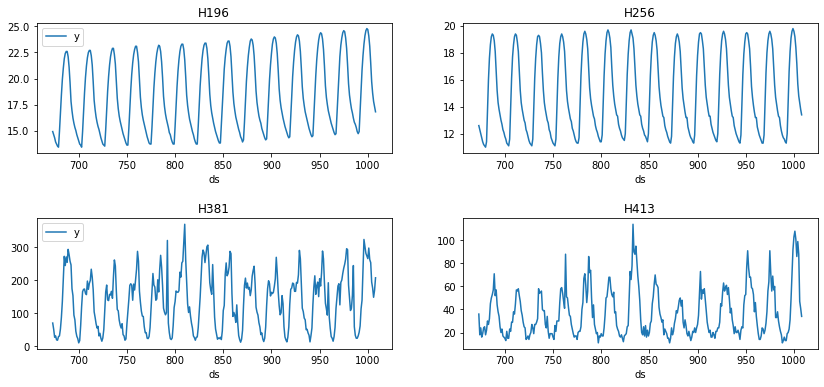

In [ ]:
plot(df)

We can use the `MLForecast.preprocess` method to explore different transformations. It looks like these series have a strong seasonality on the hour of the day, so we can subtract the value from the same hour in the previous day to remove it. This can be done with the `differences`.

In [ ]:
from mlforecast import MLForecast

In [ ]:
fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq=1,  # our series have integer timestamps, so we'll just add 1 in every timestep
    differences=[24],
)
prep = fcst.preprocess(df, id_col='unique_id', time_col='ds', target_col='y').reset_index()
prep

,unique_id,ds,y
0,H196,25,0.3
1,H196,26,0.3
2,H196,27,0.1
3,H196,28,0.2
4,H196,29,0.2
...,...,...,...
3931,H413,1004,39.0
3932,H413,1005,55.0
3933,H413,1006,14.0
3934,H413,1007,3.0


This has subtacted the lag 24 from each value, we can see what our series look like now.

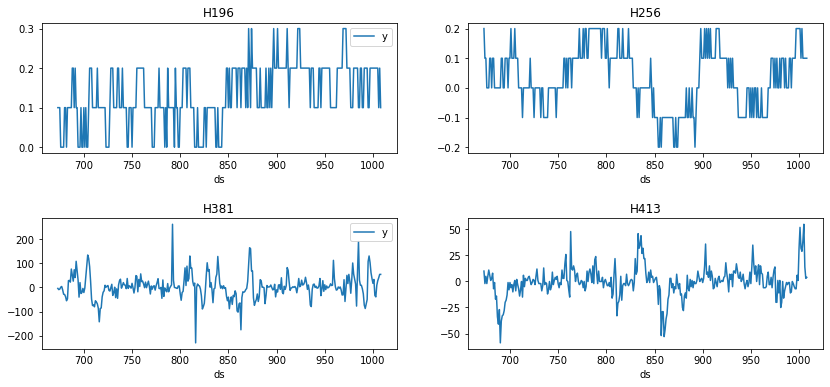

In [ ]:
plot(prep)

## Adding features

### Lags

Looks like the seasonality is gone, we can now try adding some lag features.

In [ ]:
fcst = MLForecast(
    models=[],
    freq=1,
    differences=[24],
    lags=[1, 24],
)
prep = fcst.preprocess(df, id_col='unique_id', time_col='ds', target_col='y')
prep

,ds,y,lag-1,lag-24
unique_id,,,,
H196,49,0.1,0.1,0.3
H196,50,0.1,0.1,0.3
H196,51,0.2,0.1,0.1
H196,52,0.1,0.2,0.2
H196,53,0.1,0.1,0.2
...,...,...,...,...
H413,1004,39.0,29.0,1.0
H413,1005,55.0,39.0,-25.0
H413,1006,14.0,55.0,-20.0


In [ ]:
prep.drop(columns=['ds']).corr()['y']

y         1.000000
lag-1     0.622531
lag-24   -0.234268
Name: y, dtype: float64

### Lag transforms

Lag transforms are defined as a dictionary where the keys are the lags and the values are lists of functions that transform an array. These must be [numba](http://numba.pydata.org/) jitted functions (so that computing the features doesn't become a bottleneck). There are some implemented in the [window-ops package](https://github.com/jmoralez/window_ops) but you can also implement your own.

If the function takes two or more arguments you can either:

* supply a tuple (tfm_func, arg1, arg2, ...)
* define a new function fixing the arguments

In [ ]:
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

In [ ]:
@njit
def rolling_mean_48(x):
    return rolling_mean(x, window_size=48)


fcst = MLForecast(
    models=[],
    freq=1,
    differences=[24],
    lag_transforms={
        1: [expanding_mean],
        24: [(rolling_mean, 48), rolling_mean_48],
    },
)
prep = fcst.preprocess(df, id_col='unique_id', time_col='ds', target_col='y')
prep

,ds,y,expanding_mean_lag-1,rolling_mean_lag-24_window_size-48,rolling_mean_48_lag-24
unique_id,,,,,
H196,96,0.1,0.174648,0.150000,0.150000
H196,97,0.3,0.173611,0.145833,0.145833
H196,98,0.3,0.175342,0.141667,0.141667
H196,99,0.3,0.177027,0.141667,0.141667
H196,100,0.3,0.178667,0.141667,0.141667
...,...,...,...,...,...
H413,1004,39.0,0.242084,3.437500,3.437500
H413,1005,55.0,0.281633,2.708333,2.708333
H413,1006,14.0,0.337411,2.125000,2.125000


You can see that both approaches get to the same result, you can use whichever one you feel most comfortable with.

### Date features

If your time column is made of timestamps then it might make sense to extract features like week, dayofweek, quarter, etc. You can do that by passing a list of strings with [pandas time/date components](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components). You can also pass functions that will take the time column as input, as we'll show here.

In [ ]:
def hour_index(times):
    return times % 24

fcst = MLForecast(
    models=[],
    freq=1,
    differences=[24],
    date_features=[hour_index],
)
prep = fcst.preprocess(df, id_col='unique_id', time_col='ds', target_col='y')
prep

,ds,y,hour_index
unique_id,,,
H196,25,0.3,1
H196,26,0.3,2
H196,27,0.1,3
H196,28,0.2,4
H196,29,0.2,5
...,...,...,...
H413,1004,39.0,20
H413,1005,55.0,21
H413,1006,14.0,22


## Training

Once you've decided the features, transformations and models that you want to use you can use the `MLForecast.fit` method instead, which will do the preprocessing and then train the models.

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models=[
        lgb.LGBMRegressor(**lgb_params),
        lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),        
    ],
    freq=1,
    differences=[24],
    lags=[1, 24],
    lag_transforms={
        1: [expanding_mean],
        24: [(rolling_mean, 48)],
    },
    date_features=[hour_index],
)
fcst.fit(df, id_col='unique_id', time_col='ds', target_col='y')

MLForecast(models=[LGBMRegressor, LGBMRegressor, LGBMRegressor], freq=1, lag_features=['lag-1', 'lag-24', 'expanding_mean_lag-1', 'rolling_mean_lag-24_window_size-48'], date_features=[<function hour_index>], num_threads=1)

This computed the features and trained three different models using them. We can now compute our forecasts.

## Forecasting

In [ ]:
preds = fcst.predict(48).reset_index()
preds.columns = ['unique_id', 'ds', 'avg', 'q75', 'q25']
preds

,unique_id,ds,avg,q75,q25
0,H196,1009,16.295257,16.385859,16.320666
1,H196,1010,15.910282,16.012728,15.856905
2,H196,1011,15.728367,15.784867,15.656658
3,H196,1012,15.468414,15.503223,15.401462
4,H196,1013,15.081279,15.163606,15.048576
...,...,...,...,...,...
187,H413,1052,100.450617,116.461898,52.276952
188,H413,1053,88.426800,114.257158,50.866960
189,H413,1054,59.675737,89.672526,16.440738
190,H413,1055,57.580356,84.680943,14.248400


In [ ]:
import pandas as pd

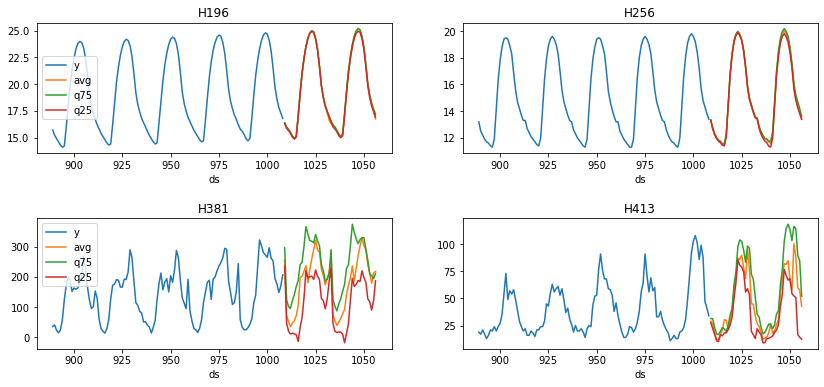

In [ ]:
plot(pd.concat([df, preds]), last_n=24 * 7)

## Estimating the model's performance

In order to get an estimate of how well our model will be when predicting future data we can perform cross validation, which consist on training a few models on different subsets of the data, using them to predict a validation set and measuring their performance.

Since our data depends on time, we make our splits by removing the last portions of the series and using them as validation sets. This process is implemented in `MLForecast.cross_validation`.

In [ ]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq=1,
    differences=[24],
    lags=[1, 24],
    lag_transforms={
        1: [expanding_mean],
        24: [(rolling_mean, 48)],
    },
    date_features=[hour_index],
)
cv_result = fcst.cross_validation(
    df,
    n_windows=4,  # number of models to train/splits to perform
    window_size=48,  # length of the validation set in each window
    id_col='unique_id',
    time_col='ds',
    target_col='y',
)
cv_result

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,817,816,15.3,15.383165
1,H196,818,816,14.9,14.923219
2,H196,819,816,14.6,14.667834
3,H196,820,816,14.2,14.275964
4,H196,821,816,13.9,13.973491
...,...,...,...,...,...
763,H413,1004,960,99.0,65.644823
764,H413,1005,960,88.0,71.717097
765,H413,1006,960,47.0,76.704377
766,H413,1007,960,41.0,53.446638


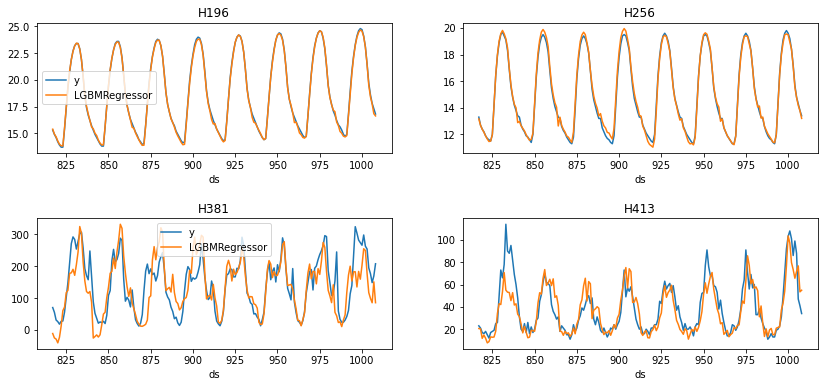

In [ ]:
plot(cv_result.drop(columns='cutoff'))

We can compute the RMSE on each split.

In [ ]:
def evaluate_cv(df):
    return df['y'].sub(df['LGBMRegressor']).pow(2).groupby(df['cutoff']).mean().pow(0.5)

split_rmse = evaluate_cv(cv_result)
split_rmse

cutoff
816    29.418172
864    34.257598
912    13.145763
960    35.066261
dtype: float64

And the average RMSE across splits.

In [ ]:
split_rmse.mean()

27.971948676289266

You can quickly try different features and evaluate them this way. We can try removing the differencing and using an exponentially weighted average of the lag 1 instead of the expanding mean.

In [ ]:
from window_ops.ewm import ewm_mean

In [ ]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq=1,
    lags=[1, 24],
    lag_transforms={
        1: [(ewm_mean, 0.5)],
        24: [(rolling_mean, 48)],      
    },
    date_features=[hour_index],    
)
cv_result2 = fcst.cross_validation(
    df,
    n_windows=4,
    window_size=48,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
)
evaluate_cv(cv_result2).mean()

25.87444576840234

## LightGBMCV